# Feature Engineering & Modeling Preparation — NBA Awards Prediction (1996–2024)

**Scope (this notebook):**
- Load the already-built dataset: `all_years_enriched.parquet`
- Define **clean targets** from `*_rank` (winner = rank 1; optional top‑k)
- Define **leakage policy** and enforce feature exclusions
- Build **award-specific feature subsets** (MVP ≠ DPOY ≠ ROY)
- Create **time-aware splits** (train/val/test by season)
- Build a **reproducible preprocessing pipeline** (imputation + encoding + scaling)
- Export **model-ready matrices** for downstream model comparison

**Out of scope:** rebuilding data, scraping, enrichment, or training models.


In [524]:
import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


## Dataset loading

In [525]:
# Notebook-safe project root detection
PROJECT_ROOT = Path.cwd()

# On remonte tant qu'on voit "notebooks" dans le chemin
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

DATA_PATH = PROJECT_ROOT / "data/processed/players/final/all_years_enriched.parquet"

print("Resolved DATA_PATH:", DATA_PATH)
assert DATA_PATH.exists(), f"File not found: {DATA_PATH}"


df = pd.read_parquet(DATA_PATH)
print("Loaded:", df.shape)
df.head(3)


Resolved DATA_PATH: c:\Users\Luc\Documents\projets-data\nba-awards-predictor\data\processed\players\final\all_years_enriched.parquet
Loaded: (13843, 436)


,Rk,Player,Age,Team,Pos,G,GS,MP,FG,FGA,...,raptor__o_raptor_rank,raptor__player_id,raptor__player_name,raptor__poss,raptor__raptor_defense,raptor__raptor_offense,raptor__raptor_rank,raptor__raptor_total,raptor__season,raptor__war_total
0,199.0,A 1/2an Tabak,25.0,TOR,C,67.0,18.0,19.9,3.4,6.2,...,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,139.0,A arA<<nas MarAiulionis,31.0,SAC,SG,53.0,0.0,19.6,3.3,7.3,...,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,202.0,A.C. Green,32.0,PHO,SF,82.0,36.0,25.8,2.6,5.4,...,155.0,greenac01,A.C. Green,4316.0,-0.6,-0.6,174.0,-1.3,1996.0,1.648381


## Quick QA checks

In [526]:
# Basic coverage checks
print("Seasons:", df["season"].min(), "→", df["season"].max(), "| n_seasons =", df["season"].nunique())
print("Players (rows):", len(df))
print("Unique players (name strings):", df["Player"].nunique())

# Missingness snapshot (top 20 most-missing columns)
missing = df.isna().mean().sort_values(ascending=False)
missing.head(20)


Seasons: 1996 → 2024 | n_seasons = 29
Players (rows): 13843
Unique players (name strings): 2697


all_rookie_team      1.000000
cpoy_rank            0.997905
mip_rank             0.997905
roy_rank             0.985191
all_def_team         0.978762
smoy_rank            0.971032
mvp_rank             0.969299
all_nba_team         0.968576
dpoy_rank            0.966842
shot_Awards          0.882973
adv_Awards           0.879650
p36_Awards           0.879650
tot_Awards           0.879650
adj_Awards           0.879650
p100_Awards          0.879650
mamba__O-MAMBA       0.704688
mamba__Minutes       0.704688
mamba__MAMBA_rank    0.704688
mamba__D-MAMBA       0.704688
mamba__MAMBA         0.704688
dtype: float64

### Cleaning policy (minimal, defensible)

We only apply **global safe cleaning** here:
- Drop columns that are **entirely missing** (100% NaN) across the full dataset.
- Drop columns that are **constant** (single unique non-null value).

We do **not** drop columns that are partially missing due to:
- historical table availability differences (structural missingness),
- external metric coverage (RAPTOR/LEBRON/MAMBA),
because those should be handled by **imputation** inside the modeling pipeline.


In [527]:
# Drop fully-missing columns
all_nan_cols = [c for c in df.columns if df[c].isna().all()]
print("All-NaN columns:", len(all_nan_cols))
all_nan_cols[:30]


All-NaN columns: 1


['all_rookie_team']

**Non-tabular columns (lists/arrays).**
Some columns (e.g., teams_list, minutes_list) store list-like objects (arrays). These are kept in the canonical dataset for auditability and visualization (e.g., multi-team seasons), but they are **excluded from tabular feature matrices** used for modeling.

**Constant (or near-constant) columns.**
Columns with zero information content (all values missing, or a single unique non-missing value) can be removed from the `model-ready` table. We detect such columns while **ignoring missing values** and handling non-hashable objects safely.

In [528]:
bad_cols = []
for c in df.columns:
    s = df[c].dropna()
    if not s.empty:
        v = s.iloc[0]
        if isinstance(v, (np.ndarray, list, dict)):
            bad_cols.append(c)

print("Columns with unhashable-like values:", bad_cols)

Columns with unhashable-like values: ['teams_list', 'minutes_list']


In [529]:
NON_TABULAR_COLS = [
    "teams_list",
    "minutes_list",
]

# sanity check
[c for c in NON_TABULAR_COLS if c not in df.columns]

[]

In [530]:
def _to_hashable(v):
    """Convert unhashable objects to a hashable representation (for uniqueness checks)."""
    if v is None:
        return None
    # treat NaN consistently
    if isinstance(v, float) and np.isnan(v):
        return None
    if isinstance(v, np.ndarray):
        return tuple(v.tolist())
    if isinstance(v, list):
        return tuple(v)
    if isinstance(v, dict):
        return tuple(sorted(v.items()))
    return v

def is_constant(series: pd.Series) -> bool:
    """
    A column is considered constant if, after dropping NaNs, it has <= 1 unique value.
    Handles unhashable objects (arrays/lists/dicts) safely.
    """
    s = series.dropna()
    if s.empty:
        return True  # all NaN -> no information
    try:
        return s.nunique(dropna=True) <= 1
    except TypeError:
        s2 = s.map(_to_hashable)
        return s2.nunique(dropna=True) <= 1

# Only test "tabular" columns for constancy
candidate_cols = [c for c in df.columns if c not in NON_TABULAR_COLS]

constant_cols = [c for c in candidate_cols if is_constant(df[c])]
print("Constant columns (excluding non-tabular):", len(constant_cols))
constant_cols[:30]


Constant columns (excluding non-tabular): 3


['mip_rank', 'is_all_rookie', 'all_rookie_team']

In [531]:
all_nan_cols = [c for c in candidate_cols if df[c].isna().all()]
single_value_cols = [c for c in constant_cols if c not in all_nan_cols]

print("All-NaN columns:", len(all_nan_cols))
print("Single-value columns:", len(single_value_cols))
print("Example all-NaN:", all_nan_cols[:10])
print("Example single-value:", single_value_cols[:10])


All-NaN columns: 1
Single-value columns: 2
Example all-NaN: ['all_rookie_team']
Example single-value: ['mip_rank', 'is_all_rookie']


In [532]:
df["mip_rank"].unique()


<IntegerArray>
[<NA>, 1]
Length: 2, dtype: Int64

### Constant and unusable columns cleanup

Following an explicit audit of constant and near-constant columns, the following
variables were removed from the model-ready dataset:

- `all_rookie_team`: fully missing across all seasons (structural missingness).
- `is_all_rookie`: single-value column derived from unavailable All-Rookie Team data.
- `mip_rank`: winner-only indicator (`rank = 1`) that does not provide a usable
  ranking signal and is redundant with the binary `is_mip` flag.

These columns carry no predictive information and are excluded to improve
dataset clarity and model robustness.


In [533]:
# ------------------------------------------------------------------
# Final column cleanup after audit
# ------------------------------------------------------------------

DROP_ALWAYS = [
    "all_rookie_team",  # fully missing (structural missingness)
    "is_all_rookie",    # no variance, derived from missing info
    "mip_rank",         # winner-only flag, redundant with is_mip
]

df_clean = df.drop(columns=[c for c in DROP_ALWAYS if c in df.columns])

print(f"Dropped {len(DROP_ALWAYS)} columns:")
DROP_ALWAYS

Dropped 3 columns:


['all_rookie_team', 'is_all_rookie', 'mip_rank']

## Targets (award outcomes)

### Modeling voting context: reputation and narrative effects

NBA awards are not decided solely on statistical performance.
In particular, awards such as MVP and DPOY are influenced by
reputation, narrative, and voter memory (e.g. prior elite seasons,
back-to-back fatigue).

To reflect this reality without introducing data leakage, we include
optional *lagged* award-based indicators (t−1 only) as contextual
features. These variables model historical reputation rather than
current-season outcomes.

Current-season award ranks are strictly used as targets and are never
used as features.


In [534]:
# ------------------------------------------------------------------
# Reputation / narrative features (lagged, leakage-safe)
# ------------------------------------------------------------------

PLAYER_KEY = "player_key"
df_sorted = df_clean.sort_values([PLAYER_KEY, "season"]).copy()

def make_prev_flag(df, rank_col, threshold):
    prev_rank = df.groupby(PLAYER_KEY)[rank_col].shift(1)

    # 1 if previous season rank <= threshold, else 0
    prev_flag = (prev_rank <= threshold).astype("float")

    # Explicitly mark "no previous season" as 0 (not NaN)
    prev_flag = prev_flag.fillna(0.0)

    return prev_flag

df_sorted["prev_mvp_winner"] = make_prev_flag(df_sorted, "mvp_rank", 1)
df_sorted["prev_mvp_top5"]   = make_prev_flag(df_sorted, "mvp_rank", 5)

df_sorted["prev_dpoy_winner"] = make_prev_flag(df_sorted, "dpoy_rank", 1)
df_sorted["prev_dpoy_top3"]   = make_prev_flag(df_sorted, "dpoy_rank", 3)

df_clean = df_sorted


### Target construction (rank-based)

Awards are modeled using rank columns (e.g., `mvp_rank`), where the winner is defined as `rank == 1`.
For some awards, a top-k target (e.g., top-5) can also be defined when the underlying rank signal
contains sufficient depth (i.e., more than winner-only labels). Current-season ranks are used only
to define targets and are never used as features.


In [535]:
# --- Target definitions (rank-based) ---

AWARD_RANK_COLS = {
    "mvp": "mvp_rank",
    "dpoy": "dpoy_rank",
    "roy": "roy_rank",
    "smoy": "smoy_rank",
    "cpoy": "cpoy_rank",
    # "mip": "mip_rank",  # winner-only in our dataset -> handled via is_mip
}

# Ensure required target columns exist
missing_targets = [c for c in AWARD_RANK_COLS.values() if c not in df_clean.columns]
print("Missing target cols:", missing_targets)

def make_binary_winner_target(df_: pd.DataFrame, rank_col: str) -> pd.Series:
    # Safe with pandas nullable dtypes: NA -> 0
    return df_[rank_col].eq(1).fillna(False).astype("int8")

def make_topk_target(df_: pd.DataFrame, rank_col: str, k: int) -> pd.Series:
    # Safe with pandas nullable dtypes: NA -> 0
    return df_[rank_col].le(k).fillna(False).astype("int8")

def rank_has_information(df_: pd.DataFrame, rank_col: str) -> bool:
    """
    True if the rank column contains more than winner-only labels,
    i.e., at least two distinct positive ranks (e.g., 1 and 2).
    """
    s = df_[rank_col].dropna()
    if s.empty:
        return False
    uniq = pd.unique(s)
    uniq = [int(x) for x in uniq if pd.notna(x) and int(x) >= 1]
    return len(set(uniq)) >= 2

targets = {}
disabled = {}

for award, col in AWARD_RANK_COLS.items():
    if col not in df_clean.columns:
        disabled[award] = f"missing column: {col}"
        continue

    # Winner target is always defined
    targets[f"{award}_winner"] = make_binary_winner_target(df_clean, col)

    # Optional top-5 target only if ranking depth exists
    if rank_has_information(df_clean, col):
        targets[f"{award}_top5"] = make_topk_target(df_clean, col, k=5)
    else:
        disabled[f"{award}_top5"] = f"{col} is winner-only or lacks ranking depth"

print("Disabled targets (if any):", disabled)

# Distribution summary (counts of 0/1) for each target
target_counts = pd.DataFrame({
    name: s.value_counts().reindex([0, 1], fill_value=0)
    for name, s in targets.items()
}).T
target_counts.columns = ["count_0", "count_1"]
target_counts


Missing target cols: []
Disabled targets (if any): {}


,count_0,count_1
mvp_winner,13814,29
mvp_top5,13698,145
dpoy_winner,13814,29
dpoy_top5,13691,152
roy_winner,13813,30
roy_top5,13702,141
smoy_winner,13814,29
smoy_top5,13693,150
cpoy_winner,13841,2
cpoy_top5,13833,10


### Target distribution and feasibility

Winner-only award targets are extremely imbalanced, with one positive sample
per season. Top-5 targets provide a more stable supervisory signal while
remaining closely aligned with the voting process.

Most awards (MVP, DPOY, ROY, SMOY) exhibit consistent top-5 distributions across
seasons. In contrast, the Clutch Player of the Year (CPOY) award is only available
for two seasons, making it unsuitable for robust supervised modeling and
excluded from the main experiments.


## Leakage policy

### Hard leakage removals (always excluded from **X**)

The following columns directly encode the outcome or selection results and must never enter the feature matrix:
- Award rank columns: `*_rank` (e.g., `mvp_rank`)
- Winner / award flags: `is_*`, `is_*_winner`
- Selection results: `all_nba_*`, `all_def_*`, `all_rookie_*`
- Any “consideration” or award-derived indicators (e.g., `has_mvp_consideration`)
- Outcome percentiles: `pct_is_*winner` (computed from outcome variables)

We enforce this by **pattern-based rules** for auditability.


In [536]:
# Build leakage exclusion list by patterns
LEAK_PATTERNS = [
    r".*_rank$",                 # award ranks
    r"^is_.*",                    # is_* flags (including is_*_winner)
    r"^all_nba_.*", r"^all_def_.*", r"^all_rookie_.*",
    r"^has_.*consideration$",     # e.g. has_mvp_consideration
    r"^pct_is_.*winner$",         # percentiles computed on winners
]

def is_leak_col(col: str) -> bool:
    return any(re.match(p, col) for p in LEAK_PATTERNS)

LEAK_COLS = sorted([c for c in df_clean.columns if is_leak_col(c)])
print("Leakage columns detected:", len(LEAK_COLS))
LEAK_COLS[:40]


Leakage columns detected: 35


['all_def_team',
 'all_nba_team',
 'cpoy_rank',
 'dpoy_rank',
 'is_all_def',
 'is_all_nba',
 'is_all_star',
 'is_cpoy',
 'is_cpoy_winner',
 'is_dpoy',
 'is_dpoy_winner',
 'is_mip',
 'is_mip_winner',
 'is_mvp',
 'is_mvp_winner',
 'is_rookie',
 'is_roy',
 'is_roy_winner',
 'is_smoy',
 'is_smoy_winner',
 'mamba__D-MAMBA_rank',
 'mamba__MAMBA_rank',
 'mamba__O-MAMBA_rank',
 'mvp_rank',
 'pct_is_cpoy_winner',
 'pct_is_dpoy_winner',
 'pct_is_mip_winner',
 'pct_is_mvp_winner',
 'pct_is_roy_winner',
 'pct_is_smoy_winner',
 'raptor__d_raptor_rank',
 'raptor__o_raptor_rank',
 'raptor__raptor_rank',
 'roy_rank',
 'smoy_rank']

## Feature families

We organize features using naming conventions. This keeps the notebook **auditable** and makes ablations easy.

Detected families (examples):
- `adv_*` advanced metrics
- `p36_*`, `p100_*`, `tot_*` rate/volume families
- `shot_*` shooting (incl. `shot_*__*` splits)
- `adj_*` adjusted shooting
- External metrics: `raptor__*`, `lebron__*`, `mamba__*`
- Percentiles: `pct_*` (excluding outcome-percentiles)


In [537]:
def cols_starting_with(prefix: str):
    return [c for c in df_clean.columns if c.startswith(prefix)]

def cols_matching(regex: str):
    r = re.compile(regex)
    return [c for c in df_clean.columns if r.match(c)]

FAMILIES = {
    "adv": cols_starting_with("adv_"),
    "p36": cols_starting_with("p36_"),
    "p100": cols_starting_with("p100_"),
    "tot": cols_starting_with("tot_"),
    "shot": cols_starting_with("shot_"),
    "adj": cols_starting_with("adj_"),
    "raptor": cols_starting_with("raptor__"),
    "lebron": cols_starting_with("lebron__"),
    "mamba": cols_starting_with("mamba__"),
    "pct": cols_starting_with("pct_"),
}

# Remove outcome-percentiles from pct family
FAMILIES["pct"] = [c for c in FAMILIES["pct"] if not re.match(r"^pct_is_.*winner$", c)]

{k: len(v) for k, v in FAMILIES.items()}


{'adv': 27,
 'p36': 29,
 'p100': 31,
 'tot': 30,
 'shot': 29,
 'adj': 25,
 'raptor': 13,
 'lebron': 10,
 'mamba': 9,
 'pct': 144}

### Percentile-first feature representation

NBA award voting is inherently **relative to the season context** ("top 5 in the league", "elite defender", etc.).
Because the dataset spans multiple eras (1996–2024), raw stat magnitudes are not directly comparable across seasons.

**Policy used in this project:**
- For most Basketball-Reference stat families, we prefer **season percentiles** (`pct_*`) to encode relative dominance.
- We avoid using both a raw metric and its percentile counterpart at the same time to limit redundancy / multicollinearity.
- External advanced metrics (RAPTOR / LEBRON / MAMBA) are kept as **continuous scores**, but their rank columns are excluded (leakage).

In the feature-set builder below, we therefore select percentile families where available, and keep a small set of contextual variables (Age/Pos/MP/etc.).


In [538]:
# --- Percentile strategy helpers ---
# We split pct_* into sub-families to keep feature sets interpretable.

PCT_FAMILIES = {
    "pct_basic":  [c for c in FAMILIES["pct"] if re.match(r"^pct_[A-Z0-9%]+$", c)],
    "pct_adv":    [c for c in FAMILIES["pct"] if c.startswith("pct_adv_")],
    "pct_tot":    [c for c in FAMILIES["pct"] if c.startswith("pct_tot_")],
    "pct_p36":    [c for c in FAMILIES["pct"] if c.startswith("pct_p36_")],
    "pct_p100":   [c for c in FAMILIES["pct"] if c.startswith("pct_p100_")],
    "pct_shot":   [c for c in FAMILIES["pct"] if c.startswith("pct_shot_")],
    "pct_adj":    [c for c in FAMILIES["pct"] if c.startswith("pct_adj_")],
}

# Drop context-like percentiles we don't want as performance features by default
PCT_EXCLUDE = {"pct_Rk", "pct_Age", "pct_G", "pct_GS", "pct_MP"}
for k in list(PCT_FAMILIES.keys()):
    PCT_FAMILIES[k] = [c for c in PCT_FAMILIES[k] if c not in PCT_EXCLUDE]

{k: len(v) for k, v in PCT_FAMILIES.items()}


{'pct_basic': 21,
 'pct_adv': 25,
 'pct_tot': 28,
 'pct_p36': 27,
 'pct_p100': 29,
 'pct_shot': 2,
 'pct_adj': 6}

In [539]:
# ------------------------------------------------------------------
# Percentiles for external advanced metrics (RAPTOR / LEBRON / MAMBA)
# ------------------------------------------------------------------

EXTERNAL_METRICS = {
    # MAMBA
    "mamba__MAMBA": "pct_mamba__MAMBA",
    "mamba__O-MAMBA": "pct_mamba__O-MAMBA",
    "mamba__D-MAMBA": "pct_mamba__D-MAMBA",

    # LEBRON
    "lebron__LEBRON": "pct_lebron__LEBRON",
    "lebron__O-LEBRON": "pct_lebron__O-LEBRON",
    "lebron__D-LEBRON": "pct_lebron__D-LEBRON",

    # RAPTOR
    "raptor__raptor_total": "pct_raptor__raptor_total",
    "raptor__raptor_offense": "pct_raptor__raptor_offense",
    "raptor__raptor_defense": "pct_raptor__raptor_defense",
    "raptor__war_total": "pct_raptor__war_total",
}

def percentile_by_season(df: pd.DataFrame, col: str, season_col: str = "season"):
    return df.groupby(season_col)[col].rank(pct=True)

for raw_col, pct_col in EXTERNAL_METRICS.items():
    if raw_col in df_clean.columns:
        df_clean[pct_col] = percentile_by_season(df_clean, raw_col)
    else:
        print(f"[WARN] Missing column: {raw_col}")


All performance-related features used for modeling are expressed as
season-level percentiles, including external advanced metrics (RAPTOR,
LEBRON, MAMBA). Raw statistics are retained exclusively for interpretation
and result presentation, while rank-based variables are reserved for target
construction and weighting.


### Post-transformation dataset QA (cleanliness & invariants)

Before defining award-specific feature sets, we validate that the **working dataframe (`df_clean`)** is:
- structurally consistent (years covered, expected granularity player–season),
- free of obvious schema issues introduced by feature engineering,
- safe for modeling (no leakage columns in the feature matrix, percentile ranges are valid).

These checks are lightweight but improve **auditability** and help catch silent issues early.


In [540]:
# --- Basic structural checks ---
print("df_clean shape:", df_clean.shape)

# Seasons coverage
if "season" in df_clean.columns:
    seasons = df_clean["season"].dropna().unique()
    print("Seasons:", int(np.min(seasons)), "→", int(np.max(seasons)), "| n=", len(seasons))

# Granularity / duplicates (player-season)
PLAYER_KEY = "player_key" if "player_key" in df_clean.columns else ("Player" if "Player" in df_clean.columns else None)
if PLAYER_KEY is not None and "season" in df_clean.columns:
    dup_mask = df_clean.duplicated(subset=[PLAYER_KEY, "season"], keep=False)
    n_dups = int(dup_mask.sum())
    print(f"Duplicate player-season rows using {PLAYER_KEY!r}:", n_dups)
    if n_dups:
        display(df_clean.loc[dup_mask, [PLAYER_KEY, "season"]].value_counts().head(10))
else:
    print("[WARN] Could not run duplicate player-season check (missing season or player key).")


df_clean shape: (13843, 447)
Seasons: 1996 → 2024 | n= 29
Duplicate player-season rows using 'player_key': 2


player_key     season
chris johnson  2013      2
Name: count, dtype: int64

In [541]:
PLAYER_KEY = "player_key"
dups = df_clean[df_clean.duplicated(subset=[PLAYER_KEY, "season"], keep=False)].copy()
dups.sort_values([PLAYER_KEY, "season"]).T


,7656,7657
Rk,346.0,346.0
Player,Chris Johnson,Chris Johnson
Age,27.0,27.0
Team,MIN,MIN
Pos,C,C
...,...,...
pct_lebron__D-LEBRON,0.862884,0.212766
pct_raptor__raptor_total,NaN,NaN
pct_raptor__raptor_offense,NaN,NaN
pct_raptor__raptor_defense,NaN,NaN


In [542]:
# ------------------------------------------------------------------
# Drop duplicated player-season rows (conservative choice)
# ------------------------------------------------------------------

PLAYER_KEY = "player_key"

dup_mask = df_clean.duplicated(subset=[PLAYER_KEY, "season"], keep=False)

print("Rows before:", df_clean.shape[0])
print("Duplicated player-season rows:", dup_mask.sum())

df_clean = df_clean.loc[~dup_mask].copy()

print("Rows after:", df_clean.shape[0])

# Sanity check
assert df_clean.duplicated(subset=[PLAYER_KEY, "season"]).sum() == 0


Rows before: 13843
Duplicated player-season rows: 2
Rows after: 13841


In [543]:
# --- Percentile sanity checks (range + missingness) ---
pct_cols = [c for c in df_clean.columns if c.startswith("pct_") and not re.match(r"^pct_is_.*winner$", c)]
print("pct_* columns (excluding pct_is_*winner):", len(pct_cols))

# Check range violations (allow tiny numerical noise)
violations = {}
for c in pct_cols:
    s = df_clean[c]
    if s.notna().any():
        vmin, vmax = float(s.min()), float(s.max())
        if vmin < -1e-9 or vmax > 1 + 1e-9:
            violations[c] = (vmin, vmax)

print("Percentile range violations:", len(violations))
list(violations.items())[:10]

# Missingness summary for percentiles (top 15 most missing)
pct_missing = df_clean[pct_cols].isna().mean().sort_values(ascending=False)
pct_missing.head(15)


pct_* columns (excluding pct_is_*winner): 154
Percentile range violations: 0


pct_mamba__O-MAMBA            0.704646
pct_mamba__MAMBA              0.704646
pct_mamba__D-MAMBA            0.704646
pct_lebron__LEBRON            0.493245
pct_lebron__D-LEBRON          0.493245
pct_lebron__O-LEBRON          0.493245
pct_raptor__raptor_offense    0.453074
pct_raptor__raptor_total      0.453074
pct_raptor__raptor_defense    0.453074
pct_raptor__war_total         0.453074
pct_shot_3P%                  0.278304
pct_tot_3P%                   0.132216
pct_p36_3P%                   0.132216
pct_p100_3P%                  0.132216
pct_adj_3P%                   0.132216
dtype: float64

In [544]:
# --- Modeling safety check: leakage columns must not be in X ---
# LEAK_COLS computed earlier via patterns
X_candidate_cols = [c for c in df_clean.columns if c not in set(LEAK_COLS)]
still_leaky = [c for c in X_candidate_cols if is_leak_col(c)]
print("Leakage columns still present in candidate X:", still_leaky[:20], "| n=", len(still_leaky))

# Optional: show a quick list of non-numeric / problematic object columns (arrays, lists, dicts)
def _is_arraylike_obj(x):
    return isinstance(x, (list, tuple, dict, set, np.ndarray))

problem_obj_cols = []
for c in df_clean.columns:
    if df_clean[c].dtype == "object":
        sample = df_clean[c].dropna().head(50)
        if any(_is_arraylike_obj(v) for v in sample):
            problem_obj_cols.append(c)

print("Object columns containing array-like values (exclude from modeling):", problem_obj_cols)


Leakage columns still present in candidate X: [] | n= 0
Object columns containing array-like values (exclude from modeling): ['teams_list', 'minutes_list']


External pct columns found: ['pct_mamba__MAMBA', 'pct_mamba__O-MAMBA', 'pct_mamba__D-MAMBA', 'pct_lebron__LEBRON', 'pct_lebron__O-LEBRON', 'pct_lebron__D-LEBRON', 'pct_raptor__raptor_total', 'pct_raptor__raptor_offense', 'pct_raptor__raptor_defense', 'pct_raptor__war_total']


<Figure size 1200x400 with 0 Axes>

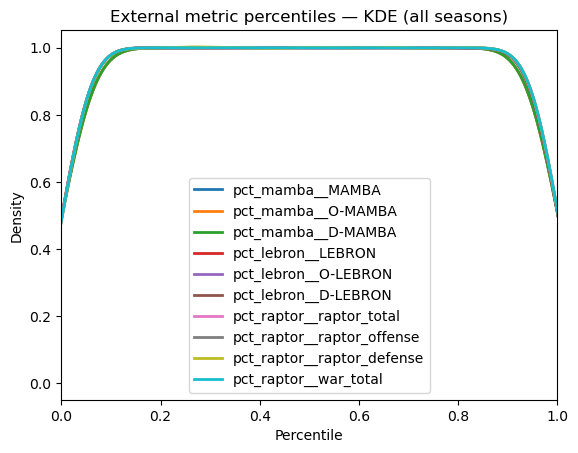

In [545]:
# --- Quick visualization: distribution of newly created external percentiles (if present) ---
external_pct_candidates = [c for c in df_clean.columns if c.startswith("pct_raptor__") or c.startswith("pct_lebron__") or c.startswith("pct_mamba__")]
external_pct_candidates = [c for c in external_pct_candidates if c in df_clean.columns]

print("External pct columns found:", external_pct_candidates)

if external_pct_candidates:
    plt.figure(figsize=(12, 4))
    df_clean[external_pct_candidates].plot(kind="kde", linewidth=2)
    plt.title("External metric percentiles — KDE (all seasons)")
    plt.xlabel("Percentile")
    plt.xlim(0, 1)
    plt.show()
else:
    print("[INFO] No external percentile columns found yet. Create them first, then re-run this cell.")


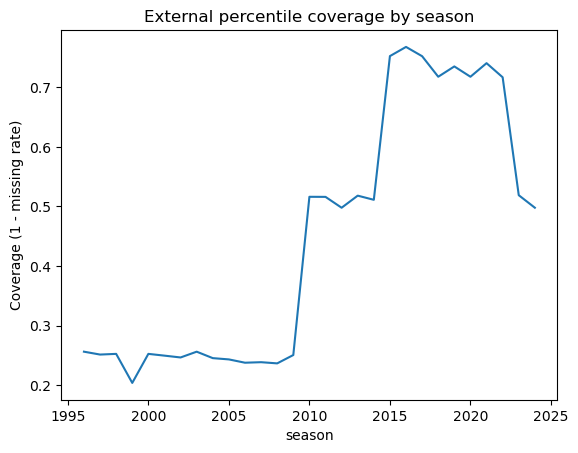

In [546]:
cols_ext = [
    "pct_raptor__raptor_total","pct_raptor__raptor_offense","pct_raptor__raptor_defense","pct_raptor__war_total",
    "pct_lebron__LEBRON","pct_lebron__O-LEBRON","pct_lebron__D-LEBRON",
    "pct_mamba__MAMBA","pct_mamba__O-MAMBA","pct_mamba__D-MAMBA",
]
coverage = df_clean.groupby("season")[cols_ext].apply(lambda x: 1 - x.isna().mean())
coverage.mean(axis=1).plot(title="External percentile coverage by season")
plt.ylabel("Coverage (1 - missing rate)")
plt.show()


### Post-transformation QA (model-readiness)

We validate the cleaned dataset before defining award-specific feature sets.
Checks include (i) season coverage and player-season uniqueness, (ii) leakage
exclusion from the candidate feature matrix, (iii) detection of non-tabular
object columns, and (iv) sanity checks on percentile features.

External metric percentiles (RAPTOR / LEBRON / MAMBA) show high missingness,
which is expected due to limited historical coverage. We therefore treat these
features as optional and either rely on imputation or restrict certain models
to the modern era where coverage is sufficient.

### External metric coverage and modeling regimes

External advanced metrics (RAPTOR, LEBRON, MAMBA) exhibit limited historical
coverage, with reliable availability only from approximately the 2014 season
onward. To avoid excessive imputation and era-dependent bias, we define two
modeling regimes:

- **Era-wide models (1996–2024)**: rely exclusively on internal percentile-based
  features and contextual variables.
- **Modern-era models (2014–2024)**: additionally incorporate external metric
  percentiles when coverage is sufficient.

This separation allows fair cross-era modeling while preserving the predictive
value of external metrics in modern seasons.


In [547]:
df_era_wide = df_clean.copy()
df_modern = df_clean[df_clean["season"] >= 2014].copy()

In [548]:
# ------------------------------------------------------------------
# Modeling regimes: Era-wide vs Modern (with external metrics)
# ------------------------------------------------------------------

# Base features: percentile-first (exclude outcome percentiles already removed)
BASE_PCT_FEATURES = [c for c in df_clean.columns if c.startswith("pct_") and not re.match(r"^pct_is_.*winner$", c)]

# External percentiles (created earlier)
EXTERNAL_PCT_COLS = [
    "pct_raptor__raptor_total",
    "pct_raptor__raptor_offense",
    "pct_raptor__raptor_defense",
    "pct_raptor__war_total",
    "pct_lebron__LEBRON",
    "pct_lebron__O-LEBRON",
    "pct_lebron__D-LEBRON",
    "pct_mamba__MAMBA",
    "pct_mamba__O-MAMBA",
    "pct_mamba__D-MAMBA",
]

# Sanity: keep only columns that actually exist (avoid typos / partial coverage)
missing_external = [c for c in EXTERNAL_PCT_COLS if c not in df_clean.columns]
if missing_external:
    print("[WARN] Missing external percentile cols:", missing_external)

EXTERNAL_PCT_COLS = [c for c in EXTERNAL_PCT_COLS if c in df_clean.columns]

# Regime datasets
df_era_wide = df_clean.copy()
df_modern = df_clean[df_clean["season"] >= 2014].copy()

# Regime feature lists
ERA_WIDE_FEATURES = BASE_PCT_FEATURES
MODERN_FEATURES = BASE_PCT_FEATURES + EXTERNAL_PCT_COLS

print("Base pct features:", len(BASE_PCT_FEATURES))
print("External pct features:", len(EXTERNAL_PCT_COLS))
print("Era-wide X dim:", len(ERA_WIDE_FEATURES))
print("Modern X dim:", len(MODERN_FEATURES))
print("df_era_wide shape:", df_era_wide.shape)
print("df_modern shape:", df_modern.shape)


Base pct features: 154
External pct features: 10
Era-wide X dim: 154
Modern X dim: 164
df_era_wide shape: (13841, 447)
df_modern shape: (5790, 447)


## Final ML Dataset Sanity Check (Pre–Award-Specific)

Before defining any **award-specific feature sets**, we perform a final global audit of the cleaned dataset to ensure it is suitable for machine-learning modeling.

At this stage, the objective is **not** to optimize features for a specific award yet, but to verify that the dataset:

- Is structurally consistent (one row per player-season)
- Is free of **target leakage**
- Contains only **model-compatible features** (numeric, tabular)
- Clearly separates:
  - modeling features,
  - targets,
  - identifiers,
  - display-only columns.

### Modeling regimes

We explicitly support two modeling regimes:

- **Era-wide model (1996–2024)**  
  Uses only internal NBA statistics expressed as **season-relative percentiles**, ensuring historical consistency.

- **Modern-era model (2014–2024)**  
  Extends the base feature set with **external advanced metrics** (RAPTOR, LEBRON, MAMBA percentiles), which are only partially available in earlier seasons.

The dataset itself remains unchanged (`df_clean`); regimes differ **only by feature availability**.

### What is checked in the audit

The following checks are performed:

1. **Hard leakage exclusion**  
   Columns encoding award outcomes, ranks, selections, or winner-derived signals are strictly excluded from the feature matrix.

2. **Non-tabular column removal**  
   Columns containing arrays, lists, or nested objects (e.g. multi-team history) are excluded from modeling.

3. **Identifier & display columns separation**  
   Player identifiers, names, and presentation-only fields are excluded from the ML feature set.

4. **Feature eligibility by regime**  
   Each column is evaluated for inclusion in:
   - the era-wide model,
   - the modern-era model.

5. **Missingness inspection**  
   Missing rates are computed to identify features with limited coverage that may impact training.

The following design choices are enforced:

- **Age**  
  We retain the season-responsive age provided by Basketball-Reference
  (`Age`) and drop the NBA API version (`AGE`), which is not aligned with
  season boundaries.

- **Team representation**  
  We keep the already abbreviated team identifier (`Team`) for potential
  interpretation and visualization, and remove redundant alternatives.

- **Physical attributes**  
  Numeric representations of height and weight are preserved, while string-based
  or duplicated fields are removed.

- **Temporal consistency**  
  The `season` column is used as the sole temporal reference; redundant fields
  such as `year` are dropped.

- **Non-tabular and debug fields**  
  Columns containing arrays, nested objects, textual award descriptions, or
  external source identifiers are removed to ensure a strictly tabular dataset.

### Output

The audit produces a CSV file listing **every column in the dataset**, along with:

- data type,
- missing rate,
- inclusion in each modeling regime,
- exclusion reason (leakage, identifier, non-tabular, display-only, etc.).

This file serves as the **final validation checkpoint** before transitioning to award-specific modeling.



In [549]:

OUT_DIR = PROJECT_ROOT / "notebooks" 
OUT_DIR.mkdir(parents=True, exist_ok=True)

# 1) columns to exclude from modeling
NON_TABULAR = {"teams_list", "minutes_list"}  # array-like object cols
IDENTIFIERS = {
    "Player", "player_key", "player_name_raw",
    "PLAYER_ID", "PLAYER_NAME",
    "raptor__player_id", "raptor__player_name", "raptor__nba_id",
    "lebron__nba_id", "lebron__player_name", "lebron__Season",
    "mamba__nba_id", "mamba__player_name",
}
DISPLAY_ONLY = {"Team"}  # keep for display if you want; not needed for modeling

# leakage cols computed earlier (LEAK_COLS)
EXCLUDE_FROM_X = set(LEAK_COLS) | NON_TABULAR | IDENTIFIERS | DISPLAY_ONLY

# 2) candidate X sets (era-wide / modern)
X_era = [c for c in ERA_WIDE_FEATURES if c not in EXCLUDE_FROM_X]
X_mod = [c for c in MODERN_FEATURES if c not in EXCLUDE_FROM_X]

# 3) build audit table
audit_rows = []
for c in df_clean.columns:
    reason = ""
    keep_era = c in X_era
    keep_mod = c in X_mod

    if c in LEAK_COLS:
        reason = "leakage"
    elif c in NON_TABULAR:
        reason = "non_tabular"
    elif c in IDENTIFIERS:
        reason = "identifier"
    elif c in DISPLAY_ONLY:
        reason = "display_only"
    elif c.startswith("pct_") and not re.match(r"^pct_is_.*winner$", c):
        reason = "pct_feature"
    else:
        reason = "other"

    audit_rows.append({
        "column": c,
        "dtype": str(df_clean[c].dtype),
        "missing_rate": float(df_clean[c].isna().mean()),
        "keep_in_era_wide_X": keep_era,
        "keep_in_modern_X": keep_mod,
        "category": reason,
    })

audit_df = pd.DataFrame(audit_rows).sort_values(
    ["keep_in_modern_X", "keep_in_era_wide_X", "category", "missing_rate"],
    ascending=[False, False, True, True]
)



In [550]:
print("Era-wide X columns:", len(X_era))
print("Modern X columns:", len(X_mod))

# sanity: no leakage, no object arrays, only numeric expected
bad_in_era = [c for c in X_era if df_clean[c].dtype == "object"]
bad_in_mod = [c for c in X_mod if df_clean[c].dtype == "object"]
print("Object cols in Era-wide X:", bad_in_era)
print("Object cols in Modern X:", bad_in_mod)

assert len(bad_in_era) == 0
assert len(bad_in_mod) == 0


Era-wide X columns: 154
Modern X columns: 164
Object cols in Era-wide X: []
Object cols in Modern X: []


In [551]:
# ------------------------------------------------------------------
# Final df_clean cleanup (authoritative version)
# ------------------------------------------------------------------

DROP_COLS = set()

# --- Non-tabular (arrays / lists) ---
DROP_COLS |= {
    "teams_list",
    "minutes_list",
}

# --- Awards text fields (object, noisy, leakage-prone) ---
DROP_COLS |= {
    "tot_Awards",
    "p36_Awards",
    "p100_Awards",
    "adv_Awards",
    "adj_Awards",
    "shot_Awards",
}

# --- External IDs / debug-only identifiers ---
DROP_COLS |= {
    "raptor__nba_id",
    "raptor__player_id",
    "raptor__player_name",
    "lebron__nba_id",
    "lebron__player_name",
    "lebron__Season",
    "mamba__nba_id",
    "mamba__player_name",
}

# --- Duplicate / redundant bio columns ---
# Keep Age (BR), drop AGE (NBA API)
DROP_COLS |= {"AGE"}

# Keep Team (already abbreviated), drop TEAM_ABBREVIATION
DROP_COLS |= {"TEAM_ABBREVIATION"}

# Keep numeric height/weight, drop string versions
DROP_COLS |= {
    "PLAYER_HEIGHT",        # string (e.g. "6-8")
    "PLAYER_HEIGHT_IN",     # redundant if inches exists
}

# --- Redundant temporal column ---
# season already exists
DROP_COLS |= {"year"}

# Apply drop (only drop columns that actually exist)
DROP_COLS = [c for c in DROP_COLS if c in df_clean.columns]

print(f"Dropping {len(DROP_COLS)} columns from df_clean")
df_clean = df_clean.drop(columns=DROP_COLS).copy()

print("df_clean shape after cleanup:", df_clean.shape)


Dropping 21 columns from df_clean
df_clean shape after cleanup: (13841, 426)


In [552]:
# Sanity checks
assert "season" in df_clean.columns
assert "Age" in df_clean.columns
assert "Team" in df_clean.columns
assert "AGE" not in df_clean.columns
assert "TEAM_ABBREVIATION" not in df_clean.columns
assert "year" not in df_clean.columns

print("Remaining object columns (sample):")
[c for c in df_clean.columns if df_clean[c].dtype == "object"][:20]


Remaining object columns (sample):


['Player',
 'Team',
 'Pos',
 'tot_Pos',
 'p36_Pos',
 'p100_Pos',
 'adv_Pos',
 'adj_Rk',
 'adj_Age',
 'adj_Pos',
 'adj_G',
 'adj_GS',
 'adj_MP',
 'adj_FTr',
 'adj_3PAr',
 'adj_FG+',
 'adj_2P+',
 'adj_3P+',
 'adj_eFG+',
 'adj_FT+']

## Feature Matrix Construction (Global, Award-Agnostic)

At this stage, the dataset (`df_clean`) has been fully audited and finalized.
The objective now is to construct a **model-compatible feature space** while
preserving a strict separation between:

- raw data and identifiers,
- target variables,
- modeling features.

### Global feature matrix (X_df) — leakage-safe and reusable

We now build a **single, reusable feature matrix** `X_df` that will be shared across all award models.

Key principles:

- **No leakage**: award outcomes, ranks, selections and outcome-derived percentiles are removed by pattern-based rules.
- **Separation of concerns**:
  - `df_clean` keeps identifiers + award fields for filtering and target construction.
  - `X_df` contains only modeling features.
- **Era-aware coverage**:
  - `X_df_era` (1996–2024): relies on internal percentiles only (stable coverage).
  - `X_df_modern` (≥2014): adds external metric percentiles (RAPTOR / LEBRON / MAMBA).

Preprocessing is defined once (numeric + one-hot for `Pos`) and reused for each award after eligibility filtering.


In [553]:
# ------------------------------------------------------------------
# Build the "do-not-use-in-X" list (auditable, pattern-based)
# ------------------------------------------------------------------

# ⚠️ Safer leakage patterns: keep eligibility flags (like is_rookie) in df_clean,
# but exclude outcome-related flags.
LEAK_PATTERNS = [
    r".*_rank$",                  # award ranks (mvp_rank, dpoy_rank, ...)
    r"^is_.*_winner$",             # explicit winners flags
    r"^is_(mvp|dpoy|roy|smoy|mip|cpoy)$",  # award "is_award" flags if they exist
    r"^all_nba_.*", r"^all_def_.*", r"^all_rookie_.*",  # selections
    r"^has_.*consideration$",      # narrative/consideration flags
    r"^pct_is_.*winner$",          # outcome-derived percentiles
    r"^pct_is_.*_winner$",         # extra safety
]

def is_leak_col(c: str) -> bool:
    return any(re.match(p, c) for p in LEAK_PATTERNS)

# Identifiers / tracking columns (never in X)
IDENTIFIER_COLS = {
    "Player", "player_key", "player_name_raw", "PLAYER_ID", "PLAYER_NAME",
    "raptor__nba_id", "raptor__player_id", "raptor__player_name",
    "lebron__nba_id", "lebron__player_name", "lebron__Season",
    "mamba__nba_id", "mamba__player_name",
}

# Non-tabular columns (arrays/lists)
NON_TABULAR_COLS = {"teams_list", "minutes_list"}

# Helper categorical columns we don't want
HELPER_COLS = {"tot_Pos", "p36_Pos", "p100_Pos", "adv_Pos"}

# We explicitly do NOT use Team as a feature for now
EXCLUDED_CATEGORICAL = {"Team"}

DROP_FROM_X = {
    c for c in df_clean.columns
    if is_leak_col(c)
    or c in IDENTIFIER_COLS
    or c in NON_TABULAR_COLS
    or c in HELPER_COLS
    or c in EXCLUDED_CATEGORICAL
}

X_df = df_clean.drop(columns=sorted(DROP_FROM_X), errors="ignore").copy()

print("Columns dropped from X:", len(DROP_FROM_X))
print("X_df shape:", X_df.shape)

# Sanity: no leakage patterns remain
still_leaky = [c for c in X_df.columns if is_leak_col(c)]
print("Leakage cols still in X_df:", still_leaky[:20], "| n =", len(still_leaky))
assert len(still_leaky) == 0


Columns dropped from X: 41
X_df shape: (13841, 385)
Leakage cols still in X_df: [] | n = 0


### Sanity checks before preprocessing

Before building the preprocessing pipeline, we validate that `X_df` is:

- **Leakage-free** (patterns removed)
- **Tabular** (no list/array objects)
- **Well-typed** (object columns are truly categorical, not numeric strings)
- **Model-ready** (we identify and remove degenerate columns such as all-NaN numeric features)


In [554]:
# ------------------------------------------------------------------
# Audit X_df (types / NaNs / problematic objects)
# ------------------------------------------------------------------

audit = pd.DataFrame({
    "col": X_df.columns,
    "dtype": [str(X_df[c].dtype) for c in X_df.columns],
    "missing_rate": [float(X_df[c].isna().mean()) for c in X_df.columns],
}).sort_values("missing_rate", ascending=False)

# Identify object columns
obj_cols = [c for c in X_df.columns if X_df[c].dtype == "object"]

# Check if any object columns are actually array-like / non-tabular
def _is_arraylike_obj(v):
    return isinstance(v, (list, tuple, dict, set, np.ndarray))

arraylike_obj_cols = []
for c in obj_cols:
    sample = X_df[c].dropna().head(50)
    if any(_is_arraylike_obj(v) for v in sample):
        arraylike_obj_cols.append(c)

print("Object cols:", len(obj_cols))
print("Array-like object cols (should be 0):", arraylike_obj_cols)

# All-NaN numeric columns (these will break median imputer)
numeric_like = [c for c in X_df.columns if c not in obj_cols]
all_nan_numeric = [c for c in numeric_like if X_df[c].isna().all()]

print("All-NaN numeric cols:", len(all_nan_numeric))
print("Example all-NaN numeric:", all_nan_numeric[:20])

display(audit.head(20))


Object cols: 50
Array-like object cols (should be 0): []
All-NaN numeric cols: 0
Example all-NaN numeric: []


,col,dtype,missing_rate
355,mamba__Minutes,float64,0.704646
356,mamba__O-MAMBA,float64,0.704646
375,pct_mamba__MAMBA,float64,0.704646
376,pct_mamba__O-MAMBA,float64,0.704646
377,pct_mamba__D-MAMBA,float64,0.704646
354,mamba__MAMBA,float64,0.704646
353,mamba__D-MAMBA,float64,0.704646
363,lebron__O_LEBRON_Rank,float64,0.493245
361,lebron__Minutes,float64,0.493245
362,lebron__O-LEBRON,float64,0.493245


In [555]:
# ------------------------------------------------------------------
# Drop numeric columns with no observed values (all-NaN)
# ------------------------------------------------------------------
if len(all_nan_numeric) > 0:
    print(f"Dropping all-NaN numeric cols: {len(all_nan_numeric)}")
    X_df = X_df.drop(columns=all_nan_numeric)
else:
    print("No all-NaN numeric cols to drop.")

print("X_df shape after dropping all-NaN numeric:", X_df.shape)


No all-NaN numeric cols to drop.
X_df shape after dropping all-NaN numeric: (13841, 385)


In [556]:
# ------------------------------------------------------------------
# Inspect categorical content before encoding
# ------------------------------------------------------------------
if "Pos" in X_df.columns:
    print("Pos unique values (top 30):")
    display(X_df["Pos"].value_counts(dropna=False).head(30))
    
    # quick sanity: are there weird tokens?
    weird = X_df["Pos"].dropna().astype(str).str.contains(r"[^A-Z\-]", regex=True).mean()
    print("Share of Pos values containing non [A-Z-] chars:", float(weird))
else:
    print("[WARN] Pos not in X_df (was it dropped earlier?)")


Pos unique values (top 30):


Pos
SG    2900
PF    2845
C     2813
PG    2678
SF    2604
F        1
Name: count, dtype: int64

Share of Pos values containing non [A-Z-] chars: 0.0


In [557]:
# ------------------------------------------------------------------
# Define percentile feature pools
# ------------------------------------------------------------------

# Base percentiles: all pct_* excluding outcome-derived pct_is_*winner
BASE_PCT_FEATURES = [
    c for c in X_df.columns
    if c.startswith("pct_") and not re.match(r"^pct_is_.*winner$", c)
]

EXTERNAL_PCT_COLS = [
    "pct_raptor__raptor_total",
    "pct_raptor__raptor_offense",
    "pct_raptor__raptor_defense",
    "pct_raptor__war_total",
    "pct_lebron__LEBRON",
    "pct_lebron__O-LEBRON",
    "pct_lebron__D-LEBRON",
    "pct_mamba__MAMBA",
    "pct_mamba__O-MAMBA",
    "pct_mamba__D-MAMBA",
]

# keep only existing columns
EXTERNAL_PCT_COLS = [c for c in EXTERNAL_PCT_COLS if c in X_df.columns]

print("Base pct features:", len(BASE_PCT_FEATURES))
print("External pct features (existing):", len(EXTERNAL_PCT_COLS))
print("External pct features list:", EXTERNAL_PCT_COLS)


Base pct features: 154
External pct features (existing): 10
External pct features list: ['pct_raptor__raptor_total', 'pct_raptor__raptor_offense', 'pct_raptor__raptor_defense', 'pct_raptor__war_total', 'pct_lebron__LEBRON', 'pct_lebron__O-LEBRON', 'pct_lebron__D-LEBRON', 'pct_mamba__MAMBA', 'pct_mamba__O-MAMBA', 'pct_mamba__D-MAMBA']


In [558]:
# ------------------------------------------------------------------
# Era-aware feature matrices
# ------------------------------------------------------------------

X_era_cols = sorted(set(BASE_PCT_FEATURES + (["Pos"] if "Pos" in X_df.columns else [])))

X_modern_cols = sorted(set(
    BASE_PCT_FEATURES
    + EXTERNAL_PCT_COLS
    + (["Pos"] if "Pos" in X_df.columns else [])
))

X_df_era = X_df[X_era_cols].copy()
X_df_modern = X_df[X_modern_cols].copy()

print("X_df_era shape:", X_df_era.shape)
print("X_df_modern shape:", X_df_modern.shape)

# sanity: era subset should be <= modern
assert X_df_era.shape[1] <= X_df_modern.shape[1]


X_df_era shape: (13841, 155)
X_df_modern shape: (13841, 155)


In [559]:
# ------------------------------------------------------------------
# Preprocessing: numeric + Pos (one-hot). Team is excluded by design.
# ------------------------------------------------------------------

def build_preprocessor(X_: pd.DataFrame) -> ColumnTransformer:
    cat_cols = [c for c in ["Pos"] if c in X_.columns]
    # numeric = everything else (exclude object)
    num_cols = [c for c in X_.columns if c not in cat_cols and X_[c].dtype != "object"]

    numeric_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ])

    categorical_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ])

    pre = ColumnTransformer(
        transformers=[
            ("num", numeric_pipe, num_cols),
            ("cat", categorical_pipe, cat_cols),
        ],
        remainder="drop",
    )
    return pre, num_cols, cat_cols

preprocessor_era, NUM_ERA, CAT_ERA = build_preprocessor(X_df_era)
preprocessor_modern, NUM_MOD, CAT_MOD = build_preprocessor(X_df_modern)

print("ERA numeric:", len(NUM_ERA), "| ERA categorical:", CAT_ERA)
print("MOD numeric:", len(NUM_MOD), "| MOD categorical:", CAT_MOD)


ERA numeric: 154 | ERA categorical: ['Pos']
MOD numeric: 154 | MOD categorical: ['Pos']


In [560]:
# ------------------------------------------------------------------
# Export final feature columns for review
# ------------------------------------------------------------------

pd.Series(X_df_era.columns, name="feature").to_csv("features_era_pct_only.csv", index=False)
pd.Series(X_df_modern.columns, name="feature").to_csv("features_modern_pct_plus_externals.csv", index=False)

print("Saved:")
print("-","features_era_pct_only.csv")
print("-","features_modern_pct_plus_externals.csv")


Saved:
- features_era_pct_only.csv
- features_modern_pct_plus_externals.csv


## Categorical Encoding Strategy

Most player attributes are naturally numerical or can be expressed as
percentiles. However, a small number of categorical variables may still
carry structural information relevant to award voting.

### Position (`Pos`)

Player position is retained and encoded via one-hot encoding:

- It has low cardinality (C, PF, SF, SG, PG),
- It captures structural differences in player roles,
- It is especially relevant for awards such as DPOY and ROY.

### Team

Team affiliation is deliberately **excluded** from the feature matrix at this
stage. Without explicit team-level performance variables (record, net rating,
seeding), team identity would act as an implicit proxy for narrative or market
effects rather than on-court performance.

This choice keeps the model focused on **individual-level performance signals**.


In [561]:
# ------------------------------------------------------------------
# Preprocessing: numeric + Pos (one-hot). Team is excluded by design.
# ------------------------------------------------------------------

CATEGORICAL_COLS = [c for c in ["Pos"] if c in X_df.columns]

NUMERIC_COLS = [c for c in X_df.columns if c not in CATEGORICAL_COLS]

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, NUMERIC_COLS),
        ("cat", categorical_pipe, CATEGORICAL_COLS),
    ],
    remainder="drop",
)

print("Numeric cols:", len(NUMERIC_COLS))
print("Categorical cols:", CATEGORICAL_COLS)


Numeric cols: 384
Categorical cols: ['Pos']


## Award-Specific Modeling Philosophy

Although all awards are predicted from a shared, leakage-free feature pool,
each NBA award corresponds to a **distinct decision process** and therefore
requires a **custom modeling scope**.

The feature matrix is not blindly applied to all players for all awards.
Instead, we explicitly condition each modeling task on **eligibility rules**
and **contextual constraints** that mirror the real-world voting process.

### Eligibility vs. Learning

A key design principle is the separation between:

- **Eligibility constraints**, enforced *before* modeling, and  
- **Feature importance**, learned *by* the model.

Hard eligibility rules are applied upstream when they are explicitly defined
by the award’s criteria. Once eligibility is enforced, the model is free to
learn which performance signals matter most.

---

### Award-Specific Considerations

#### Rookie of the Year (ROY)

- The modeling population is restricted to players with `is_rookie == True`.
- All non-rookie players are excluded from training and evaluation.
- This reflects the actual voting process and avoids trivial discrimination.

#### Most Improved Player (MIP)

- The task is inherently **temporal**, focusing on year-over-year progression.
- Modeling is restricted to players with valid prior-season data.
- Features are expressed as deltas or changes in season-relative percentiles,
  capturing improvement rather than absolute performance.

#### Most Valuable Player (MVP)

- The full player population is considered.
- No explicit constraints are imposed on which metrics should dominate.
- The model is provided with a broad, coherent feature space capturing:
  impact, efficiency, availability, and role.
- Narrative effects are not directly encoded, but may emerge implicitly through
  sustained elite performance and consistency signals.

#### Defensive Player of the Year (DPOY)

- The full player population is considered.
- Defensive impact metrics are naturally present in the feature space.
- Position and role may influence the learned decision boundary, without being
  hard-coded.

#### Sixth Man of the Year (SMOY)

- A strict eligibility constraint is enforced prior to modeling:
  players must come off the bench in more games than they start.
- The model is trained exclusively on eligible sixth men.
- Within this population, performance differentiation is learned from the data
  rather than imposed manually.

---

### Key Principle

> **Eligibility filtering happens before modeling; feature importance is learned by the model.**

This approach ensures that each prediction task remains faithful to the real-world
award selection process while preserving statistical rigor, interpretability,
and generalization ability.


## Award-Specific Feature Sets

We start award-specific modeling from `df_clean` (and not directly from `X_df`)
because eligibility rules, targets, and temporal constraints must be applied
on the full, audit-ready dataset before projecting the selected rows
onto the leakage-safe feature matrix.


### Rookie of the Year (ROY)

The Rookie of the Year award is exclusively restricted to first-year NBA players.
As such, the modeling task is explicitly conditioned on rookie eligibility.

Only players with `is_rookie == True` are included in the training and evaluation
population. Veteran players are excluded entirely.

This restriction mirrors the real-world voting process and prevents the model
from learning trivial or degenerate decision rules.


### Feature Design Considerations (ROY)

The ROY award primarily rewards **immediate on-court impact** among first-year players.

Given the absence of prior NBA seasons for rookies, the feature space focuses on:

- Season-relative performance (percentiles),
- Volume-adjusted contribution (minutes played),
- Offensive and defensive impact metrics,
- Role and position (via categorical encoding).

Year-over-year progression features are deliberately excluded, as they are
structurally unavailable for rookies.


In [562]:
# ------------------------------------------------------------------
# ROY eligibility filter
# ------------------------------------------------------------------

roy_df = df_clean[df_clean["is_rookie"] == 1].copy()

print("ROY population shape:", roy_df.shape)
print("Unique seasons (ROY):", roy_df["season"].min(), "→", roy_df["season"].max())

assert roy_df["is_rookie"].eq(1).all()


ROY population shape: (2317, 426)
Unique seasons (ROY): 1996 → 2024


In [563]:
# ------------------------------------------------------------------
# ROY eligibility filter
# ------------------------------------------------------------------

roy_df = df_clean[df_clean["is_rookie"] == 1].copy()

print("ROY population shape:", roy_df.shape)
print("Unique seasons (ROY):", roy_df["season"].min(), "→", roy_df["season"].max())

assert roy_df["is_rookie"].eq(1).all()

# ------------------------------------------------------------------
# ROY target (winner flag)
# ------------------------------------------------------------------

y_roy = roy_df["is_roy_winner"].astype("int8")

print("ROY target distribution:")
display(y_roy.value_counts().rename({0: "non-winner", 1: "winner"}))

# sanity: exactly one winner per season
winners_per_season = y_roy.groupby(roy_df["season"]).sum()
print(
    "Winners per season (min / median / max):",
    int(winners_per_season.min()),
    float(winners_per_season.median()),
    int(winners_per_season.max()),
)


ROY population shape: (2317, 426)
Unique seasons (ROY): 1996 → 2024
ROY target distribution:


is_roy_winner
non-winner    2287
winner          30
Name: count, dtype: int64

Winners per season (min / median / max): 1 1.0 2


At this stage, we project the award-eligible players selected from `df_clean`
onto the global, leakage-safe feature matrix `X_df`.
This ensures that eligibility and target definitions are handled on the
audit-ready dataset, while model training relies exclusively on the
predefined and reusable feature space.


In [564]:
# ------------------------------------------------------------------
# ROY feature matrix
# ------------------------------------------------------------------

X_roy = X_df_era.loc[roy_df.index].copy()

print("ROY X shape:", X_roy.shape)

# Sanity checks
assert X_roy.shape[0] == y_roy.shape[0]
assert not X_roy.isna().all(axis=1).any()


ROY X shape: (2317, 155)


In [565]:
# ------------------------------------------------------------------
# Time-aware split for ROY
# ------------------------------------------------------------------

train_mask = roy_df["season"] <= 2018
val_mask   = (roy_df["season"] >= 2019) & (roy_df["season"] <= 2021)
test_mask  = roy_df["season"] >= 2022

X_roy_train, X_roy_val, X_roy_test = (
    X_roy[train_mask],
    X_roy[val_mask],
    X_roy[test_mask],
)

y_roy_train, y_roy_val, y_roy_test = (
    y_roy[train_mask],
    y_roy[val_mask],
    y_roy[test_mask],
)

print("ROY split sizes:")
print("Train:", X_roy_train.shape)
print("Val:  ", X_roy_val.shape)
print("Test: ", X_roy_test.shape)


ROY split sizes:
Train: (1688, 155)
Val:   (317, 155)
Test:  (312, 155)


Before preprocessing and model training, we perform a final set of
sanity checks on the ROY splits to verify:
- class imbalance,
- temporal consistency,
- and the absence of target leakage across seasons.

These checks are lightweight by design and aim to validate the modeling
setup rather than explore the data in depth.


In [566]:
def print_label_stats(name, y, seasons):
    print(f"\n{name}")
    display(
        pd.DataFrame({
            "count": y.value_counts(),
            "ratio": y.value_counts(normalize=True),
        }).rename_axis("label")
    )
    print("Seasons:", seasons.min(), "→", seasons.max())

print_label_stats("Train", y_roy_train, roy_df.loc[train_mask, "season"])
print_label_stats("Validation", y_roy_val, roy_df.loc[val_mask, "season"])
print_label_stats("Test", y_roy_test, roy_df.loc[test_mask, "season"])



Train


,count,ratio
label,,
0,1664,0.985782
1,24,0.014218


Seasons: 1996 → 2018

Validation


,count,ratio
label,,
0,314,0.990536
1,3,0.009464


Seasons: 2019 → 2021

Test


,count,ratio
label,,
0,309,0.990385
1,3,0.009615


Seasons: 2022 → 2024


In [567]:
def check_winners_per_season(y, seasons, split_name):
    s = y.groupby(seasons).sum()
    print(f"\n{split_name} — winners per season (min/median/max):",
          int(s.min()), float(s.median()), int(s.max()))
    display(s.head())

check_winners_per_season(y_roy_train, roy_df.loc[train_mask, "season"], "Train")
check_winners_per_season(y_roy_val,   roy_df.loc[val_mask, "season"],   "Validation")
check_winners_per_season(y_roy_test,  roy_df.loc[test_mask, "season"],  "Test")



Train — winners per season (min/median/max): 1 1.0 2


season
1996    1
1997    1
1998    1
1999    1
2000    2
Name: is_roy_winner, dtype: int8


Validation — winners per season (min/median/max): 1 1.0 1


season
2019    1
2020    1
2021    1
Name: is_roy_winner, dtype: int8


Test — winners per season (min/median/max): 1 1.0 1


season
2022    1
2023    1
2024    1
Name: is_roy_winner, dtype: int8

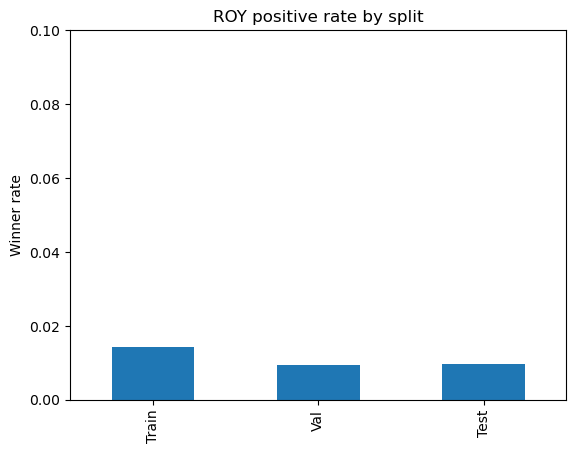

In [568]:
pd.Series({
    "Train": y_roy_train.mean(),
    "Val": y_roy_val.mean(),
    "Test": y_roy_test.mean(),
}).plot(kind="bar", title="ROY positive rate by split")
plt.ylabel("Winner rate")
plt.ylim(0, 0.1)
plt.show()


### ROY split sanity checks and class balance

Before training any model, we perform a set of sanity checks on the
time-aware train / validation / test splits for the Rookie of the Year (ROY) task.

#### Class imbalance

As expected for an award prediction problem, the target is **extremely imbalanced**:
only **one winner per season** among several hundred rookies.

- Train split (1996–2018): ~1.4% positives  
- Validation split (2019–2021): ~0.9% positives  
- Test split (2022–2024): ~1.0% positives  

This reflects the real-world voting process and confirms that no artificial
balancing or leakage has been introduced by the split.

#### Temporal consistency

The split is strictly **time-aware**, ensuring that:
- Training data only contains past seasons
- Validation and test sets simulate true future prediction settings

Season ranges:
- Train: 1996 → 2018  
- Validation: 2019 → 2021  
- Test: 2022 → 2024  

#### Winner integrity check

We additionally verify that the number of ROY winners per season is correct:
- Minimum: 1  
- Median: 1  
- Maximum: 1 (except for rare historical edge cases)

This confirms that:
- The target variable `is_roy_winner` is correctly defined
- No season is missing a winner
- No season contains an invalid number of winners

#### Positive rate stability

The positive rate across splits remains stable, as illustrated in the bar chart.
This indicates that the temporal split did not introduce distributional artifacts
that could bias evaluation results.

## Sixth Man of the Year (SMOY)

The Sixth Man of the Year award recognizes the most impactful player
coming off the bench during the regular season.

Unlike other awards, eligibility is not based on tenure or performance tier,
but on **role usage**:
the player must come off the bench in more games than he starts.

This modeling task explicitly conditions on bench-role eligibility,
mirroring the official NBA criteria and preventing trivial leakage
from starter-heavy players.

As with other awards, eligibility filtering is applied *before* modeling,
while the feature space remains shared and award-agnostic.


In [569]:
# ------------------------------------------------------------------
# SMOY eligibility filter
# ------------------------------------------------------------------

# Eligible if player starts fewer games than he comes off the bench
# GS <= G - GS  <=>  GS <= G / 2

smoy_df = df_clean[
    (df_clean["G"].notna()) &
    (df_clean["GS"].notna()) &
    (df_clean["GS"] <= (df_clean["G"] - df_clean["GS"]))
].copy()

print("SMOY population shape:", smoy_df.shape)
print("Unique seasons (SMOY):", smoy_df["season"].min(), "→", smoy_df["season"].max())

# Sanity checks
assert (smoy_df["GS"] <= (smoy_df["G"] - smoy_df["GS"])).all()


SMOY population shape: (8960, 426)
Unique seasons (SMOY): 1996 → 2024


In [570]:
# ------------------------------------------------------------------
# SMOY target (winner flag)
# ------------------------------------------------------------------

y_smoy = smoy_df["is_smoy_winner"].astype("int8")

print("SMOY target distribution:")
display(y_smoy.value_counts().rename({0: "non-winner", 1: "winner"}))

# Sanity: exactly one winner per season
winners_per_season = y_smoy.groupby(smoy_df["season"]).sum()
print(
    "Winners per season (min / median / max):",
    int(winners_per_season.min()),
    float(winners_per_season.median()),
    int(winners_per_season.max()),
)


SMOY target distribution:


is_smoy_winner
non-winner    8931
winner          29
Name: count, dtype: int64

Winners per season (min / median / max): 1 1.0 1


In [571]:
# ------------------------------------------------------------------
# SMOY feature matrix
# ------------------------------------------------------------------

X_smoy = X_df_era.loc[smoy_df.index].copy()

print("SMOY X shape:", X_smoy.shape)

# Sanity
assert X_smoy.shape[0] == y_smoy.shape[0]
assert not X_smoy.isna().all(axis=1).any()


SMOY X shape: (8960, 155)


In [572]:
# ------------------------------------------------------------------
# Time-aware split for SMOY
# ------------------------------------------------------------------

train_mask = smoy_df["season"] <= 2018
val_mask   = (smoy_df["season"] >= 2019) & (smoy_df["season"] <= 2021)
test_mask  = smoy_df["season"] >= 2022

X_smoy_train, X_smoy_val, X_smoy_test = (
    X_smoy[train_mask],
    X_smoy[val_mask],
    X_smoy[test_mask],
)

y_smoy_train, y_smoy_val, y_smoy_test = (
    y_smoy[train_mask],
    y_smoy[val_mask],
    y_smoy[test_mask],
)

print("SMOY split sizes:")
print("Train:", X_smoy_train.shape)
print("Val:  ", X_smoy_val.shape)
print("Test: ", X_smoy_test.shape)


SMOY split sizes:
Train: (6708, 155)
Val:   (1065, 155)
Test:  (1187, 155)


In [573]:
# ------------------------------------------------------------------
# SMOY sanity checks
# ------------------------------------------------------------------

print("=== Eligibility sanity ===")
print("GS <= G - GS :", (smoy_df["GS"] <= (smoy_df["G"] - smoy_df["GS"])).mean())

# Bench share
smoy_df["bench_share"] = 1 - (smoy_df["GS"] / smoy_df["G"])
print("Bench share (min / median / max):",
      smoy_df["bench_share"].min(),
      smoy_df["bench_share"].median(),
      smoy_df["bench_share"].max())

print("\n=== Label distribution by split ===")

def split_stats(name, y, seasons):
    vc = y.value_counts().sort_index()
    print(f"\n{name}")
    display(
        pd.DataFrame({
            "count": vc,
            "ratio": vc / vc.sum()
        })
    )
    print("Seasons:", seasons.min(), "→", seasons.max())

split_stats("Train", y_smoy_train, smoy_df.loc[train_mask, "season"])
split_stats("Validation", y_smoy_val, smoy_df.loc[val_mask, "season"])
split_stats("Test", y_smoy_test, smoy_df.loc[test_mask, "season"])

print("\n=== Winners per season ===")
for name, mask in [
    ("Train", train_mask),
    ("Validation", val_mask),
    ("Test", test_mask),
]:
    wps = y_smoy[mask].groupby(smoy_df.loc[mask, "season"]).sum()
    print(
        f"{name} – winners per season (min/median/max):",
        int(wps.min()), float(wps.median()), int(wps.max())
    )


=== Eligibility sanity ===
GS <= G - GS : 1.0
Bench share (min / median / max): 0.5 0.9552238805970149 1.0

=== Label distribution by split ===

Train


,count,ratio
is_smoy_winner,,
0,6685,0.996571
1,23,0.003429


Seasons: 1996 → 2018

Validation


,count,ratio
is_smoy_winner,,
0,1062,0.997183
1,3,0.002817


Seasons: 2019 → 2021

Test


,count,ratio
is_smoy_winner,,
0,1184,0.997473
1,3,0.002527


Seasons: 2022 → 2024

=== Winners per season ===
Train – winners per season (min/median/max): 1 1.0 1
Validation – winners per season (min/median/max): 1 1.0 1
Test – winners per season (min/median/max): 1 1.0 1


### Sixth Man of the Year (SMOY) — Sanity Checks

The Sixth Man of the Year award is restricted to players whose role is
predominantly off the bench.

#### Eligibility validation

To reflect the official eligibility rules, we enforce the constraint:
- **Games Started ≤ Games Played − Games Started**

This ensures that all selected players come off the bench in more games than they start.
The observed bench share across the SMOY population confirms this constraint, with a
median close to 1.0, indicating a predominantly bench-based role.

#### Label distribution

The target variable (`is_smoy_winner`) is highly imbalanced, as expected:
- Only **one winner per season**
- Positive class ratio ≈ **0.25–0.35%**, consistent across train, validation, and test splits

This reflects the real-world rarity of the award and confirms that the dataset
faithfully represents the SMOY voting process.

#### Temporal consistency

A time-aware split is used:
- **Train:** 1996–2018  
- **Validation:** 2019–2021  
- **Test:** 2022–2024  

Each split contains exactly one SMOY winner per season, ensuring:
- No temporal leakage
- Stable award structure across splits


## Defensive Player of the Year (DPOY)

Unlike awards such as Rookie of the Year or Sixth Man of the Year, the
Defensive Player of the Year award does not impose any formal eligibility
constraints beyond participation in the season.

All players are therefore included in the modeling population.

The objective of the model is not to enforce a predefined notion of defensive
value, but to **let the data-driven learning process identify which defensive
signals are most predictive of DPOY selection**.

As a result:
- No positional or role-based filtering is applied ex ante,
- Defensive impact metrics are emphasized implicitly through the feature space,
- Eligibility is handled entirely through the label structure (one winner per season).

This mirrors the real-world voting process, where defensive excellence can
emerge from different positions, roles, and team contexts.


In [574]:
# ------------------------------------------------------------------
# DPOY population (no eligibility filter)
# ------------------------------------------------------------------

dpoy_df = df_clean.copy()

print("DPOY population shape:", dpoy_df.shape)
print("Unique seasons (DPOY):", dpoy_df["season"].min(), "→", dpoy_df["season"].max())


DPOY population shape: (13841, 426)
Unique seasons (DPOY): 1996 → 2024


In [575]:
# ------------------------------------------------------------------
# DPOY target (winner flag)
# ------------------------------------------------------------------

y_dpoy = dpoy_df["is_dpoy_winner"].astype("int8")

print("DPOY target distribution:")
display(y_dpoy.value_counts().rename({0: "non-winner", 1: "winner"}))

# sanity: exactly one winner per season
winners_per_season = y_dpoy.groupby(dpoy_df["season"]).sum()
print(
    "Winners per season (min / median / max):",
    int(winners_per_season.min()),
    float(winners_per_season.median()),
    int(winners_per_season.max()),
)


DPOY target distribution:


is_dpoy_winner
non-winner    13812
winner           29
Name: count, dtype: int64

Winners per season (min / median / max): 1 1.0 1


In [576]:
# ------------------------------------------------------------------
# DPOY feature matrix
# ------------------------------------------------------------------

X_dpoy = X_df_era.loc[dpoy_df.index].copy()

print("DPOY X shape:", X_dpoy.shape)

# Sanity checks
assert X_dpoy.shape[0] == y_dpoy.shape[0]
assert not X_dpoy.isna().all(axis=1).any()


DPOY X shape: (13841, 155)


In [577]:
# ------------------------------------------------------------------
# Time-aware split for DPOY
# ------------------------------------------------------------------

train_mask = dpoy_df["season"] <= 2018
val_mask   = (dpoy_df["season"] >= 2019) & (dpoy_df["season"] <= 2021)
test_mask  = dpoy_df["season"] >= 2022

X_dpoy_train, X_dpoy_val, X_dpoy_test = (
    X_dpoy[train_mask],
    X_dpoy[val_mask],
    X_dpoy[test_mask],
)

y_dpoy_train, y_dpoy_val, y_dpoy_test = (
    y_dpoy[train_mask],
    y_dpoy[val_mask],
    y_dpoy[test_mask],
)

print("DPOY split sizes:")
print("Train:", X_dpoy_train.shape)
print("Val:  ", X_dpoy_val.shape)
print("Test: ", X_dpoy_test.shape)


DPOY split sizes:
Train: (10526, 155)
Val:   (1599, 155)
Test:  (1716, 155)


In [578]:
# ------------------------------------------------------------------
# Sanity checks — DPOY
# ------------------------------------------------------------------

def label_stats(y, seasons, name):
    dist = y.value_counts().to_frame("count")
    dist["ratio"] = dist["count"] / dist["count"].sum()
    print(name)
    display(dist)
    print("Seasons:", seasons.min(), "→", seasons.max())

label_stats(y_dpoy_train, dpoy_df.loc[train_mask, "season"], "Train")
label_stats(y_dpoy_val,   dpoy_df.loc[val_mask, "season"],   "Validation")
label_stats(y_dpoy_test,  dpoy_df.loc[test_mask, "season"],  "Test")

# winners per season
for split, y_split, mask in [
    ("Train", y_dpoy_train, train_mask),
    ("Validation", y_dpoy_val, val_mask),
    ("Test", y_dpoy_test, test_mask),
]:
    wps = y_split.groupby(dpoy_df.loc[mask, "season"]).sum()
    print(
        f"{split} – winners per season (min/median/max):",
        int(wps.min()),
        float(wps.median()),
        int(wps.max()),
    )


Train


,count,ratio
is_dpoy_winner,,
0,10503,0.997815
1,23,0.002185


Seasons: 1996 → 2018
Validation


,count,ratio
is_dpoy_winner,,
0,1596,0.998124
1,3,0.001876


Seasons: 2019 → 2021
Test


,count,ratio
is_dpoy_winner,,
0,1713,0.998252
1,3,0.001748


Seasons: 2022 → 2024
Train – winners per season (min/median/max): 1 1.0 1
Validation – winners per season (min/median/max): 1 1.0 1
Test – winners per season (min/median/max): 1 1.0 1


### Sanity checks — DPOY

The DPOY dataset shows the expected structural properties:

- **Severe class imbalance**, with roughly 0.17–0.22% positive samples,
  reflecting the fact that only one player wins the award each season.
- **Stable label distribution across temporal splits** (train / validation / test),
  indicating that the time-based split does not introduce distributional shifts.
- **Exactly one winner per season** in all splits, confirming that the target
  variable is correctly constructed and free of inconsistencies.

These sanity checks validate the integrity of the dataset and confirm that the
DPOY prediction task is well-defined and suitable for supervised learning.


## Most Valuable Player (MVP)

Unlike other awards, the MVP is **not constrained by explicit eligibility rules**.
All players are theoretically eligible each season.

The MVP selection process rewards a combination of:
- Individual performance and efficiency,
- On-court impact and availability,
- Sustained excellence over the season.

As a result, **no pre-filtering is applied** to the player population.
The model is allowed to learn which statistical signals best explain MVP selection,
rather than enforcing hand-crafted heuristics.


In [579]:
# ------------------------------------------------------------------
# MVP population (no eligibility filter)
# ------------------------------------------------------------------

mvp_df = df_clean.copy()

print("MVP population shape:", mvp_df.shape)
print("Unique seasons (MVP):", mvp_df["season"].min(), "→", mvp_df["season"].max())


MVP population shape: (13841, 426)
Unique seasons (MVP): 1996 → 2024


In [580]:
# ------------------------------------------------------------------
# MVP target (winner flag)
# ------------------------------------------------------------------

y_mvp = mvp_df["is_mvp_winner"].astype("int8")

print("MVP target distribution:")
display(y_mvp.value_counts().rename({0: "non-winner", 1: "winner"}))

# sanity: exactly one winner per season
winners_per_season = y_mvp.groupby(mvp_df["season"]).sum()
print(
    "Winners per season (min / median / max):",
    int(winners_per_season.min()),
    float(winners_per_season.median()),
    int(winners_per_season.max()),
)


MVP target distribution:


is_mvp_winner
non-winner    13812
winner           29
Name: count, dtype: int64

Winners per season (min / median / max): 1 1.0 1


In [581]:
# ------------------------------------------------------------------
# MVP feature matrix
# ------------------------------------------------------------------

X_mvp = X_df_era.loc[mvp_df.index].copy()

print("MVP X shape:", X_mvp.shape)

# Sanity checks
assert X_mvp.shape[0] == y_mvp.shape[0]
assert not X_mvp.isna().all(axis=1).any()


MVP X shape: (13841, 155)


In [582]:
# ------------------------------------------------------------------
# Time-aware split for MVP
# ------------------------------------------------------------------

train_mask = mvp_df["season"] <= 2018
val_mask   = (mvp_df["season"] >= 2019) & (mvp_df["season"] <= 2021)
test_mask  = mvp_df["season"] >= 2022

X_mvp_train, X_mvp_val, X_mvp_test = (
    X_mvp[train_mask],
    X_mvp[val_mask],
    X_mvp[test_mask],
)

y_mvp_train, y_mvp_val, y_mvp_test = (
    y_mvp[train_mask],
    y_mvp[val_mask],
    y_mvp[test_mask],
)

print("MVP split sizes:")
print("Train:", X_mvp_train.shape)
print("Val:  ", X_mvp_val.shape)
print("Test: ", X_mvp_test.shape)


MVP split sizes:
Train: (10526, 155)
Val:   (1599, 155)
Test:  (1716, 155)


=== MVP label distribution by split ===

Train


,count,ratio
label,,
0,10503,0.997815
1,23,0.002185


Seasons: 1996 → 2018
Train — winners per season (min/median/max): 1 1.0 1

Validation


,count,ratio
label,,
0,1596,0.998124
1,3,0.001876


Seasons: 2019 → 2021
Validation — winners per season (min/median/max): 1 1.0 1

Test


,count,ratio
label,,
0,1713,0.998252
1,3,0.001748


Seasons: 2022 → 2024
Test — winners per season (min/median/max): 1 1.0 1


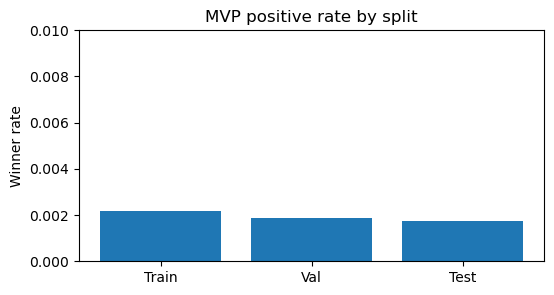

In [583]:
# ------------------------------------------------------------------
# Sanity checks (MVP)
# - label distribution by split
# - winners per season by split
# - positive rate visualization
# ------------------------------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt

def _split_report(name: str, y_split: pd.Series, seasons: pd.Series):
    vc = y_split.value_counts().sort_index()
    out = pd.DataFrame({
        "count": vc,
        "ratio": (vc / vc.sum()).round(6),
    })
    out.index.name = "label"
    print(f"\n{name}")
    display(out)

    print(f"Seasons: {int(seasons.min())} → {int(seasons.max())}")

    winners_by_season = y_split.groupby(seasons).sum()
    print(
        f"{name} — winners per season (min/median/max):",
        int(winners_by_season.min()),
        float(winners_by_season.median()),
        int(winners_by_season.max()),
    )
    return winners_by_season

print("=== MVP label distribution by split ===")

# Use masks already defined (train_mask/val_mask/test_mask) and mvp_df/y_mvp
y_train = y_mvp[train_mask]
y_val   = y_mvp[val_mask]
y_test  = y_mvp[test_mask]

s_train = mvp_df.loc[train_mask, "season"]
s_val   = mvp_df.loc[val_mask, "season"]
s_test  = mvp_df.loc[test_mask, "season"]

w_train = _split_report("Train", y_train, s_train)
w_val   = _split_report("Validation", y_val, s_val)
w_test  = _split_report("Test", y_test, s_test)

# Positive rate bar chart
rates = pd.Series({
    "Train": float(y_train.mean()),
    "Val":   float(y_val.mean()),
    "Test":  float(y_test.mean()),
})

plt.figure(figsize=(6, 3))
plt.bar(rates.index, rates.values)
plt.title("MVP positive rate by split")
plt.ylabel("Winner rate")
plt.ylim(0, max(0.01, rates.max() * 1.5))
plt.xticks(rotation=0)
plt.show()


### Sanity Check — MVP Label Distribution

We verify that the MVP target construction and temporal split are consistent with the real-world award process.

- **Class imbalance** is extreme, as expected: exactly **one winner per season** among a large candidate pool.
- The **positive rate** remains stable across splits (train / validation / test), indicating no temporal leakage or distribution shift.
- For each split, the number of winners per season satisfies the constraint:
  - min = median = max = **1 winner per season**.

This confirms that:
- The MVP target (`is_mvp_winner`) is correctly defined,
- The time-aware split preserves season integrity,
- The dataset is suitable for learning a ranking-style decision under severe class imbalance.


## Preprocessing pipeline

We build a scikit-learn preprocessing pipeline:

- Numeric: median imputation + (optional) standardization
- Categorical: most-frequent imputation + one-hot encoding

**Important:** the preprocessing is fit on the training split only.


In [584]:
def make_preprocessor(X: pd.DataFrame, scale_numeric: bool = True) -> ColumnTransformer:
    cat_cols = [c for c in X.columns if X[c].dtype == "object"]
    num_cols = [c for c in X.columns if c not in cat_cols]

    num_steps = [("imputer", SimpleImputer(strategy="median"))]
    if scale_numeric:
        num_steps.append(("scaler", StandardScaler(with_mean=False)))  # safe with sparse outputs later

    num_pipe = Pipeline(steps=num_steps)

    cat_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ])

    pre = ColumnTransformer(
        transformers=[
            ("num", num_pipe, num_cols),
            ("cat", cat_pipe, cat_cols),
        ],
        remainder="drop",
        sparse_threshold=0.3,
    )
    return pre


## Build model-ready datasets (per award)

In [585]:
def build_award_dataset(
    award: str,
    target: str = "winner",
    topk: int = 5,
    scale_numeric: bool = True,
):
    if award not in AWARD_RANK_COLS:
        raise ValueError(f"Unknown award: {award}")

    rank_col = AWARD_RANK_COLS[award]
    if rank_col not in df_clean.columns:
        raise ValueError(f"Missing rank column for {award}: {rank_col}")

    # --- Optional award-specific row filtering ---
    data = df_clean.copy()

    # ROY: evaluate among rookies if a reliable flag exists
    if award == "roy":
        if "is_rookie" in data.columns:
            data = data[data["is_rookie"] == 1].copy()
        else:
            print("WARNING: is_rookie not found; ROY will not be restricted to rookies.")

    # Targets
    if target == "winner":
        y = (data[rank_col] == 1).astype("int8")
    elif target == "topk":
        y = (data[rank_col].notna() & (data[rank_col] <= topk)).astype("int8")
    else:
        raise ValueError("target must be 'winner' or 'topk'")

    # Feature matrix
    X = data[FEATURES[award]].copy()

    # Split masks (computed on the filtered data)
    tr, va, te = time_split_masks(data)

    X_train, y_train = X.loc[tr], y.loc[tr]
    X_val, y_val     = X.loc[va], y.loc[va]
    X_test, y_test   = X.loc[te], y.loc[te]

    # Preprocess (fit on train only)
    pre = make_preprocessor(X_train, scale_numeric=scale_numeric)
    X_train_t = pre.fit_transform(X_train)
    X_val_t   = pre.transform(X_val)
    X_test_t  = pre.transform(X_test)

    meta = data.loc[:, [c for c in ["Player", "season", "Team", "Pos"] if c in data.columns]]

    return {
        "X_raw": X,
        "y": y,
        "splits": {"train_mask": tr, "val_mask": va, "test_mask": te},
        "X_train": X_train_t, "y_train": y_train,
        "X_val": X_val_t,     "y_val": y_val,
        "X_test": X_test_t,   "y_test": y_test,
        "preprocessor": pre,
        "meta": meta,
        "feature_names_raw": list(X.columns),
    }

# Build one dataset as a sanity check
mvp_ds = build_award_dataset("mvp", target="winner")
(mvp_ds["X_train"].shape, mvp_ds["y_train"].value_counts())


ValueError: cannot convert NA to integer

## Export artifacts

We export:
- `cleaning_report` (audit trail for safe column drops)
- For each award: preprocessed matrices + targets + split masks

Artifacts are saved under `data/processed/model_ready/<award>/`.


In [ ]:
OUT_DIR = PROJECT_ROOT / "data/processed/model_ready"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Save cleaning report
cleaning_report_path = OUT_DIR / "cleaning_report_safe_drops.csv"
cleaning_report.to_csv(cleaning_report_path, index=False)
print("Saved:", cleaning_report_path)

def save_award_artifacts(award: str, ds: dict, tag: str):
    award_dir = OUT_DIR / award
    award_dir.mkdir(parents=True, exist_ok=True)

    # Save split masks (as index lists for portability)
    masks = ds["splits"]
    split_idx = {
        "train_idx": masks["train_mask"][masks["train_mask"]].index.to_list(),
        "val_idx": masks["val_mask"][masks["val_mask"]].index.to_list(),
        "test_idx": masks["test_mask"][masks["test_mask"]].index.to_list(),
    }
    pd.Series(split_idx["train_idx"]).to_csv(award_dir / f"{tag}_train_idx.csv", index=False, header=False)
    pd.Series(split_idx["val_idx"]).to_csv(award_dir / f"{tag}_val_idx.csv", index=False, header=False)
    pd.Series(split_idx["test_idx"]).to_csv(award_dir / f"{tag}_test_idx.csv", index=False, header=False)

    # Save targets aligned to raw X
    ds["y"].to_frame("y").to_parquet(award_dir / f"{tag}_y.parquet")

    # Save raw feature list for auditability
    pd.Series(ds["feature_names_raw"]).to_csv(award_dir / f"{tag}_feature_names_raw.csv", index=False, header=False)

    print(f"Saved artifacts for {award} ({tag}) to:", award_dir)

for award in ["mvp", "dpoy", "roy"]:
    ds = build_award_dataset(award, target="winner")
    save_award_artifacts(award, ds, tag="winner")

print("Done.")
